<a href="https://colab.research.google.com/github/philip-papasavvas/ml_sandbox/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing (NLP) with Python**

Look at the basics of natural language processing with **nltk** package in python.

## **Imports & installs**

Install the packages needed...

In [1]:
pip install nltk

Import the modules needed...

In [73]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import nltk
from nltk.corpus import stopwords # common words

%matplotlib inline

Download the nltk datasets.

In [53]:
nltk.download('all', quiet=True)

True

In [44]:
# import the SMS text file
sms_messages = pd.read_csv('https://raw.githubusercontent.com/philip-papasavvas/ml_sandbox/main/data/SMSSpamCollection.txt',
                           sep='\t',
                           names=['label', 'message'])

In [47]:
# look at how many spam and non-spam (labelled 'ham' messages) there are
print(f"There are {len(sms_messages[sms_messages['label'] == 'ham'])} non-spam messages")
print(f"There are {len(sms_messages[sms_messages['label'] != 'ham'])} spam messages")

There are 4825 non-spam messages
There are 747 spam messages


# **Exploratory Data Analysis**

Checkout the structure of the data

In [48]:
sms_messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Group the data by the spam ('ham') and non-spam ('spam') labelled data, to unlock some insights about this data.

In [49]:
sms_messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Think about which features we will use ahead of feature engineering. The more we know about the dataset we are looking at, the greater the ability to engineer more features from it.
*Feature engineering is a large part of spam detection in general.*

Make a new column to assess the length of the spam/non-spam messages.

In [52]:
sms_messages['length'] = sms_messages['message'].apply(len)

sms_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## **Data Visualisation**
Let's look at the difference between the lengths of the spam/non-spam messages.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1478c33b70>,
      dtype=object)

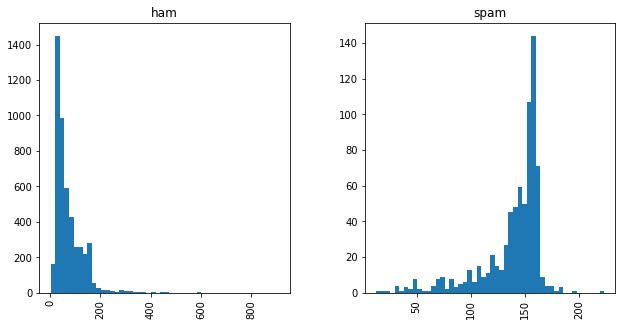

In [63]:
sms_messages.hist(column='length',
                  by='label',
                  bins=50,
                  figsize=(10,5),
                  # cannot share the same axis as there are fewer spam messages
                  # sharex=True, 
                  # sharey=True
                  )

It looks like the length distribution of the non-spam and spam messages is quite different, with the spam messages generally being longer. However one must note that the scales of the above histogram are not the same between the two labels, so confirm this using the *describe* method

In [71]:
print("Non-spam messages, length statistics \n")
sms_messages[sms_messages['label'] == 'ham'].describe().T

Non-spam messages, length statistics 



,count,mean,std,min,25%,50%,75%,max
length,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0


In [70]:
print("Spam messages, length statistics \n")
sms_messages[sms_messages['label'] != 'ham'].describe().T

Spam messages, length statistics 



,count,mean,std,min,25%,50%,75%,max
length,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


## Data pre-processing
With the data in it's current format, as text (a sequence of strings), it is not in the optimal format for a classification algorithm, a numerical feature vector.

Therefore, we will clean the data, firstly of any punctuation, and then from any of the stopwords/very common words appearing in the English language (the, a, there, etc.). We will make a function to address the first issue, and then make use of the *corpus* package within ntlk to load the stopwords/common words that do not give a sentence meaning.

In [87]:
# function to remove punctuation
sample_text = "This. is some sample! text with !punctuation in it."

# this list comprehension will remove punctuation characters
no_punc = [char for char in sample_text if char not in string.punctuation]
no_punc = "".join(no_punc)

# we can also remove punctuation using Regex too
# import re
# [re.sub("[^\w\s]", "", x) for x in sample_text]

In [88]:
no_punc

'This is some sample text with punctuation in it'

In [89]:
no_punc.split()

['This', 'is', 'some', 'sample', 'text', 'with', 'punctuation', 'in', 'it']

In [93]:
# using re
''.join([re.sub("[^\w\s]", "", x) for x in sample_text]).split()

['This', 'is', 'some', 'sample', 'text', 'with', 'punctuation', 'in', 'it']

In [96]:
# look at the stopwords too, take a sample of the first few
stopwords.words('english')[:5]

['i', 'me', 'my', 'myself', 'we']

In [103]:
# remove stopwords from a phrase
example_phrase = 'woooh this is me myself and I This has stopwords'
" ".join([x for x in example_phrase.split() if x not in stopwords.words('english')])

'woooh I This stopwords'

Now we're in a position to clean text in the following way:


* Remove punctuation
* Remove stopwords
* Return a list of cleaned words 



In [107]:
def clean_text(txt: str) -> list:
  """Method to clean input text (list)"""
  # remove punctuation from the list
  no_punc = [char for char in txt if char not in string.punctuation]
  
  # join the chaaracters with no punctuation to get the original words
  no_punc = "".join(no_punc)

  # remove stopwords
  return [word for word in no_punc.split() if 
          word not in stopwords.words('english')]
        

In [111]:
# example of clean_text method
clean_text(txt='This is! a clean. text example. Please remove stopwords')

['This', 'clean', 'text', 'example', 'Please', 'remove', 'stopwords']

In [110]:
sms_messages['message'].head(5).apply(clean_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, I, dont, think, goes, usf, lives, around...
Name: message, dtype: object

Let's compare the cleaned text to the orignal DataFrame:

In [112]:
sms_messages['message'].head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

## Tokenization
Now we want to **tokenize** the messages. That is the term given to converting the original text strings into a list of tokens (these are words that are meaningful, having removed the stopwords and punctuation).

## Normalisation
There are methods in which the text can be normalised, one example is **stemming**. This is the process of reducing a word to its word stem/root forms. A stem/root form of a word is the part of the word to which you add another part (inflectional affixes, such as -ed, -ize, -s, etc). Stems are created when the suffixes/prefixes are removed from the word.

We need to convert our list of words into a vector that can be used by scikit-learn.